## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

1. [Подготовка](#Подготовка)
2. [Анализ](#Анализ)
3. [Обучение](#Обучение)
4. [Тестирование](#Тестирование)
5. [Итоговый вывод](#Итоговый-вывод)

# Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

Сохраним данные в *data*, выбрав в качестве индексов колонку со временем, и посмотрим на них.

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Посмотрим на размер нашего датасета.

In [3]:
data.shape

(26496, 1)

У нас есть почти 26.5 тысяч объектов и один признак - количество заказов. 

Отсортируем данные по индексу, чтобы они шли по порядку.

In [4]:
data.sort_index(inplace=True)
data.index.min(), data.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

Мы имеем а распоряжении данные о заказах такси каждые десять минут с 1 марта по 31 августа 2018 года. 

Произведём ресемплирование по одниму часу, суммировав количество заказов за это время.

In [5]:
data = data.resample('1H').sum()
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [6]:
data.shape

(4416, 1)

После ресемплирования количество объектов в выборке сократилось в 6 раз.

Взглянем подробнее на эти данные.

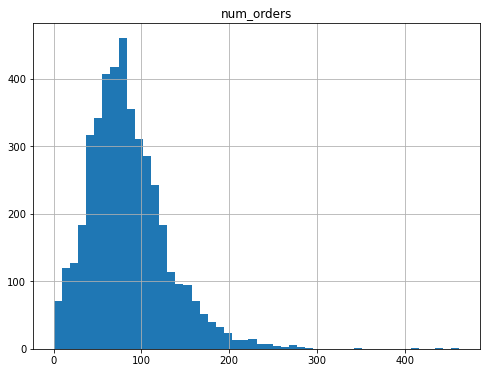

In [7]:
data.hist(bins=50, figsize=(8,6));

Чаще всего каждый час приходит по 60-80 заказов. Посмотрим на распределение заказов на графике.

По такому графику ничего не понять, заметна лишь тенденция на увеличение числа заказов с марта по август. Взглянем на подробное описание признака.

In [8]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


На протяжении 6 месяцев количество заказов каждый час находится в диапазоне от 0 до 426. При этом среднее значение заказов и медиана довольно близки: 84 и 78 заказов в час.

## Вывод

Мы открыли и изучили данные о заказах такси:
* произвели ресмплирование по часу, сократив в 6 раз количество объектов;
* выяснили, что наблюдается тенденция на увеличение числа заказов с марта по август;
* узнали, что количество заказов колеблется от 0 до 426 за час при среднем и наиболее часто встречающемся числе заказов около 80.

# Анализ

Проанализируем полученные данные. Пострим график, суммировав данные по дням, и посмотрим на распределение заказов.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

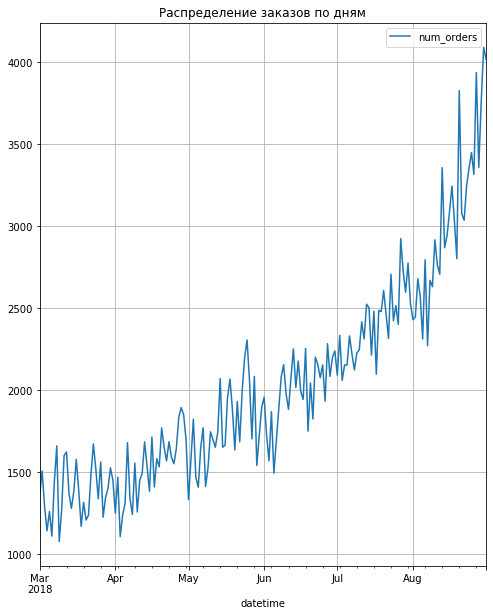

In [10]:
data.resample('1D').sum().plot(grid=True, figsize=(8,10));
plt.title('Распределение заказов по дням');

На таком графике отчётливее видно тенденцию на увеличение количества заказов со временем. При этом изо дня в день количество заказов все равно расположено хаотично. Проведём декомпозицию, чтобы посмотреть на тренды и сезонность.

In [11]:
decomposed = seasonal_decompose(data.resample('1D').sum())

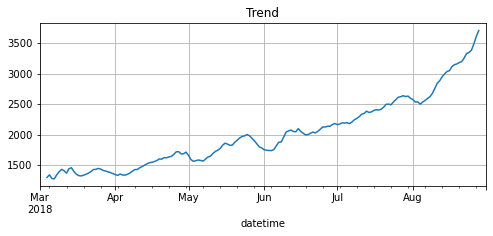

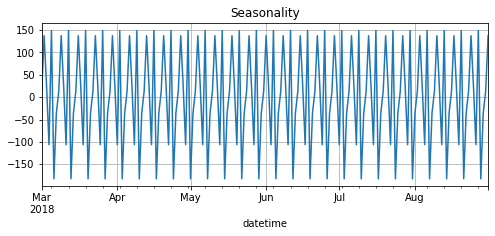

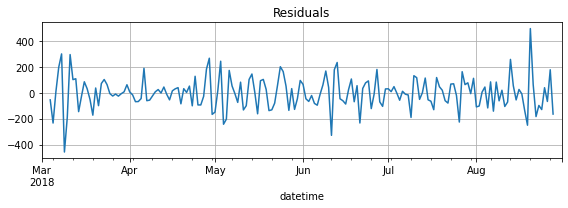

In [12]:
plt.figure(figsize=(8, 3))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.grid()
plt.figure(figsize=(8, 3))
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid()
plt.figure(figsize=(8, 3))
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.grid()
plt.tight_layout()

График трендов подтверждает нашу догадку о увеличении заказов от месяца к месяцу. Также по этому графику можно заметить, что в начале каждого месяца есть проседания по количеству заказов, а к концу месяца количество заказов вырастает.

График сезонности показывает, что в течение месяца есть колебания по количесву заказов. Просадки в заказах скорее всего связаны с выходными, когда люди чаще остаются дома, а скачки выпадают на рабочие дни.

Подробнее взглянем на сезонность за две недели, в качестве примера выберем две недели в апреле.

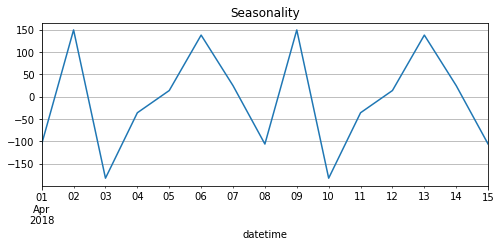

In [13]:
plt.figure(figsize=(8, 3))
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid()
plt.show()

Мы видим, что 3 и 10 числа было меньше всего заказов и это вторники, которым предшествовало два пика в понедельник, когда большинство начинает рабочую неделю. Также заметны два пика 6 и 13, это пятницы, после которых идёт постепенное уменьшение заказов вплоть до воскресенья.

Взглянем на график сезонности в течение дня.

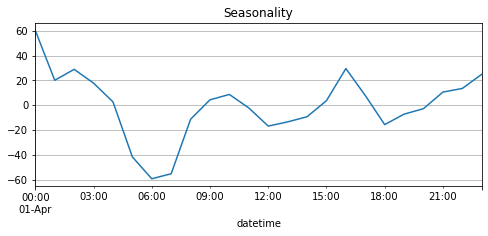

In [14]:
decomposed_day = seasonal_decompose(data)
plt.figure(figsize=(8, 3))
decomposed_day.seasonal['2018-04-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.grid()
plt.show()

На этом графике мы видим, что пик заказов приходится на ночное время, а минимум на раннее утро, когда все только просыпаются. В течение буднего времени также есть два пике, которые соотвествуют времени, когда количество рейсов в аэропортах увеличивается.

## Вывод

Проанализировав данные мы получили следующую информацию:
* График трендов подтвердил нашу догадку о повышении количества заказов такси с марта по август;
* Также обнаружились проседания в количестве заказов в начале каждого месяца;
* График сезонности по неделям выявил увеличение заказов в понедельник и пятницу и снижение заказов во вторник и выходные дни;
* График сезонности в течение дня показал, что максимум заказов приходится на ночное время, а минимум на раннее утро около 6 часов утра. Также в течение дня два пика приходятся на утреннее и вечернее время.

# Обучение

Перейдём теперь к обучению моделей и придсказаниям. Для начала напишем функцию, которая добавит к нашему датасету данные о днях недели и часах заказа, а также данные об отстающих значениях, чтобы понимать растут значения или падают, и скользящее среднее.

In [15]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Выберем максимальный размер отствания и ширину окна скользящего среднего равные 24, как часов в сутках.

In [16]:
make_features(data, 24, 24)

Выведем новый датасет.

In [17]:
data.head(10)

,num_orders,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,43.0,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,6.0,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Количество признаков увеличилось до 28.

Разделим нашу выборку на трейн и тест, отделив последнему 10% и уберём из обучающей выборки строки с пустыми значениями.

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

Посмотрим на размер полученных выборок.

In [19]:
train.shape, test.shape

((3950, 28), (442, 28))

В обучающей выборке осталось 3950 объектов, на тест отведено 442 объекта.

Проверим выборки на корректность, чтобы избежать утечки. Выведем максимальный индекс обучающей и минимальный индекс тестовой выборок.

In [20]:
train.index.max(), test.index.min()

(Timestamp('2018-08-13 13:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

Обучающая выборка заканчивается 13 августа в 13:00, а тестовая начинается 13 августа в 14:00, всё корректно. Теперь разделим выборки на признаки и целевой признак в обеих выборках.

In [21]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Теперь мы можем перейти к обучению моделей. Начнём с **линейной регрессии**.

In [22]:
model_LR = LinearRegression().fit(features_train, target_train)
predicted_LR = model_LR.predict(features_train)

Посчитаем RMSE этой модели на обучающей выборке.

In [23]:
RMSE_LR = mean_squared_error(target_train, predicted_LR)**0.5
RMSE_LR

25.840672196559467

Мы получили ошибку в 26 заказов в час.

Посмотрим на **дерево решений**, подберём параметры с помощью *GridSearchCV*. Чтобы не смешивать выборки при подборе, воспользуемся *TimeSeriesSplit* с шагом 7 (дней в неделе).

In [24]:
parametrs_dtr = { 'max_depth': [20, 30, 50],
                  'min_samples_leaf': [5, 7, 10]
                   }
tscv = TimeSeriesSplit(n_splits=7)

In [25]:
model_DTR = DecisionTreeRegressor(random_state=42)
grid_dtr = GridSearchCV(model_DTR, parametrs_dtr, cv=tscv, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

In [26]:
grid_dtr.fit(features_train, target_train)

Fitting 7 folds for each of 9 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1885s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  55 out of  63 | elapsed:    4.8s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:    4.9s finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=7),
             estimator=DecisionTreeRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50],
                         'min_samples_leaf': [5, 7, 10]},
             scoring='neg_mean_squared_error', verbose=10)

In [27]:
RMSE_DTR = (-1*grid_dtr.best_score_)**0.5
RMSE_DTR

29.755173205748832

Лучший результат - ошибка в 30 заказов в час.

In [28]:
grid_dtr.best_estimator_

DecisionTreeRegressor(max_depth=20, min_samples_leaf=10, random_state=42)

Лучшей моделю стала модель с максимальной глубиной 20 и минимальным количество листьев 10.

Теперь построим модель **случайного леса** и осмотрим на её метрику качества.

In [29]:
parametrs_rfr = { 'n_estimators': [20, 50, 100],
                  'max_depth': [20, 30, 50],
                  'min_samples_leaf': [5, 7, 10]
                   }

In [30]:
model_RFR = RandomForestRegressor(random_state=42)
grid_rfr = GridSearchCV(model_RFR, parametrs_rfr, cv=tscv, scoring='neg_mean_squared_error', verbose=10, n_jobs=-1)

In [31]:
grid_rfr.fit(features_train, target_train)

Fitting 7 folds for each of 27 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   29.9s
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed:   

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=7),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20, 30, 50],
                         'min_samples_leaf': [5, 7, 10],
                         'n_estimators': [20, 50, 100]},
             scoring='neg_mean_squared_error', verbose=10)

In [32]:
RMSE_RFR = (-1*grid_rfr.best_score_)**0.5
RMSE_RFR

25.238808935129434

Лучший результат - ошибка в 25 заказов в час.

In [33]:
grid_rfr.best_estimator_

RandomForestRegressor(max_depth=30, min_samples_leaf=5, random_state=42)

Лучшей стала модель со следующими гиперпараметрами: максимальная глубина - 30, минимальное количество листьев - 5, количество деревьев - 100.

Теперь возьмём бустинговую модель **CatBoostRegressor** с параметром *learning_rate* равным 0.1.

In [34]:
model_CBR = CatBoostRegressor(random_state=42, verbose=100, learning_rate=0.1)
model_CBR.fit(features_train, target_train)
predicted_CBR = model_CBR.predict(features_train)
RMSE_CBR = mean_squared_error(target_train, predicted_CBR)**0.5
RMSE_CBR

0:	learn: 36.8679443	total: 145ms	remaining: 2m 25s
100:	learn: 19.5802284	total: 516ms	remaining: 4.59s
200:	learn: 16.1492002	total: 936ms	remaining: 3.72s
300:	learn: 14.0752503	total: 1.38s	remaining: 3.2s
400:	learn: 12.4508647	total: 1.86s	remaining: 2.78s
500:	learn: 11.1009817	total: 2.35s	remaining: 2.34s
600:	learn: 9.9226123	total: 2.88s	remaining: 1.91s
700:	learn: 8.8982595	total: 3.37s	remaining: 1.44s
800:	learn: 7.9734670	total: 3.87s	remaining: 961ms
900:	learn: 7.1878347	total: 4.36s	remaining: 479ms
999:	learn: 6.5008552	total: 4.91s	remaining: 0us


6.5008551540476835

Точность предсказаний **CatBoost** составила 6 заказов в час. Сравним все результаты в на одном графике.

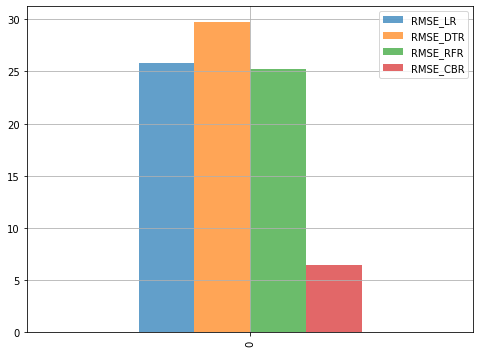

In [35]:
RMSE_all = pd.DataFrame({'RMSE_LR': [RMSE_LR],
                         'RMSE_DTR': [RMSE_DTR],
                         'RMSE_RFR': [RMSE_RFR],
                         'RMSE_CBR': [RMSE_CBR]
                        })
RMSE_all.plot(kind='bar', grid=True, figsize=(8,6), alpha=0.7);

Лучшей моделю по предсказаниям на обучающей выборке, оказался **CatBoost**, RMSE которого 6 заказов в час. **Случайный лес** выдал ошибку в 25 заказов, **линейная регрессия** справилась чуть хуже - 26 заказов. Хуже всего отработала модель **дерева решений**, её RMSE составила 30 заказов в час.

## Вывод

Мы подготовили данные и обучили несколько моделей, сравнив их результаты на обучаюей выборке.
* С помощью функции мы добавили в наш датасет дополнительные данные: календарные признаки, отстающие значения и скользящее среднее;
* Разделили новообразованный датасет на обучающую и тестовую выборки в соотношении 9:1, а затем выделили из них целевой признак - количество заказов;
* Обучили 4 модели: **линейную регрессию**, **дерево решений**, **модель случайного леса** и **CatBoost**;
* Сравнили метрику качества ***RMSE*** всех моделей и выяснили, что лучше всех отработала модель **CatBoost**, ошибка которой составила 5 заказов в час. Остальные модели показали результат в 4-5 раз хуже.

# Тестирование

Теперь посмотрим какие результат покажут наши модели на тестовом датасете. Нам нужно получить качество не более 48. Начнём с **линейной регрессии**. Поскльку модель у нас уже определена и обучена, сразу перейдём к предсказаниям и вычислению ошибки. 

In [36]:
predicted_LR = model_LR.predict(features_test)
RMSE_LR_final = mean_squared_error(target_test, predicted_LR)**0.5
RMSE_LR_final

45.17810654807807

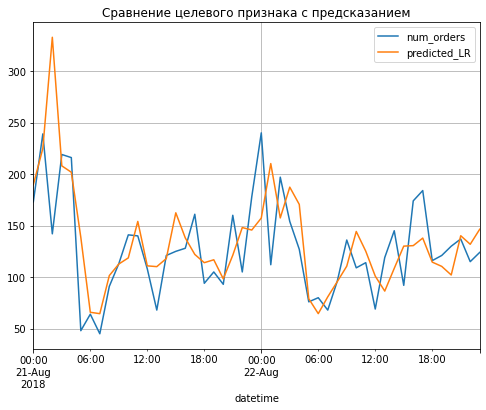

In [37]:
test_pred_LR = pd.DataFrame(target_test).join(pd.Series(predicted_LR, index=target_test.index, name='predicted_LR'))

test_pred_LR['2018-08-21':'2018-08-22'].plot(grid=True, figsize=(8,6))
plt.title('Сравнение целевого признака с предсказанием');

**Линейная регрессия** справилась с поставленной задачей - ошибка в 45 заказов. Однако, если сравнить целевой признак с предсказанием в масшатабе пары дней, то мы видим, что наша модель плохо предсказала ночные заказы 21 августа, завысив их количество на 100. Также **линейная регрессия** плохо предсказала и заказы в обеденное время, завысив их примерно на 50. 22 августа до 18:00 модель также промахнулась, предсказав заметно меньший спрос.

Посчитаем остатки.

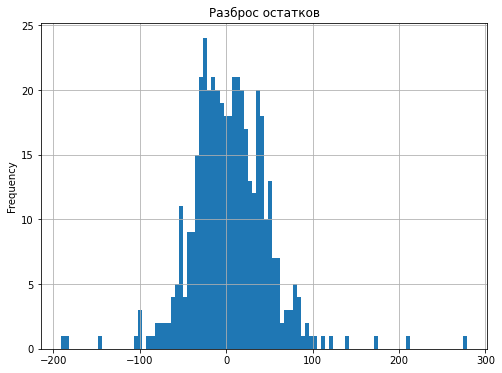

In [38]:
(target_test-predicted_LR).plot(kind='hist', grid=True, bins=100, figsize=(8,6),
                                title='Разброс остатков');

**Линейная регрессия** хорошо справилась с предсказаниями, основной разброс остатков укладывается в +/- 50 заказов, что вполне укладывается в решение нашей задачи. Однако есть исключени, и видно в частных случаях модель не справляется, ошибаясь на 100 и более заказов.

Посмотрим на **дерево решений**. Заново определим модель взяв параметры из предыдущего шага.

In [39]:
model_DTR_tune = grid_dtr.best_estimator_
model_DTR_tune.fit(features_train, target_train)
predicted_DTR = model_DTR_tune.predict(features_test)
RMSE_DTR_final = mean_squared_error(target_test, predicted_DTR)**0.5
RMSE_DTR_final

51.40967877888661

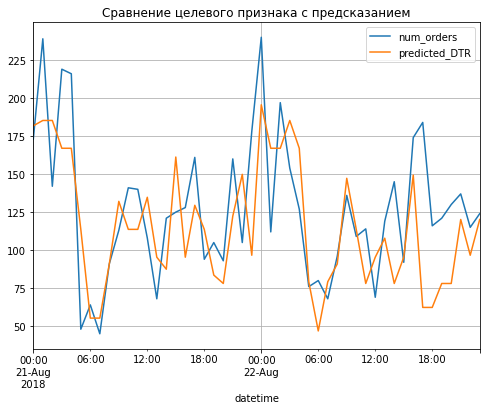

In [40]:
test_pred_DTR = pd.DataFrame(target_test).join(pd.Series(predicted_DTR, index=target_test.index, name='predicted_DTR'))

test_pred_DTR['2018-08-21':'2018-08-22'].plot(grid=True, figsize=(8,6))
plt.title('Сравнение целевого признака с предсказанием');

Эта модель не справилась с задачей, выдав ошибку в 51 заказ в час. Судя по графику, эта модель оказалась менее оптимистичной в своих предсказаниях, сильно занизив количество заказов в ночное время. Также модель промахнулась с предсказаниями утром и вечером 22 августа. Спрос в обеденное время наоборот несколько завышен.

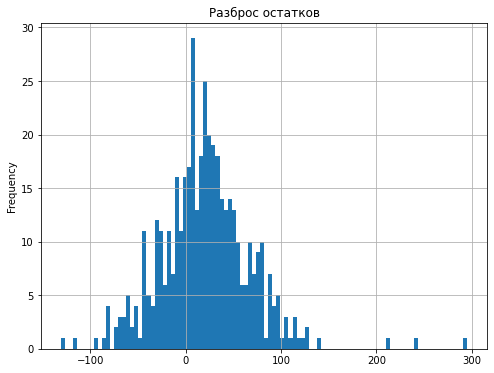

In [41]:
(target_test-predicted_DTR).plot(kind='hist', grid=True, bins=100, figsize=(8,6),
                                 title='Разброс остатков');

По этим остаткам более заметно, что **дерево решений** занижает оценку заказов, но часто предсказывает с точностью до 10 заказов. Однако и тут есть аномальные ошибки в предсказаниях, ошибающиеся почти на 300 заказов, что довольно много.

Также поступим со **случайным лесом**, взяв параметры из подбора оптимальной модели.

In [42]:
model_RFR_tune = grid_rfr.best_estimator_
model_RFR_tune.fit(features_train, target_train)
predicted_RFR = model_RFR_tune.predict(features_test)
RMSE_RFR_final = mean_squared_error(target_test, predicted_RFR)**0.5
RMSE_RFR_final

43.67974288940726

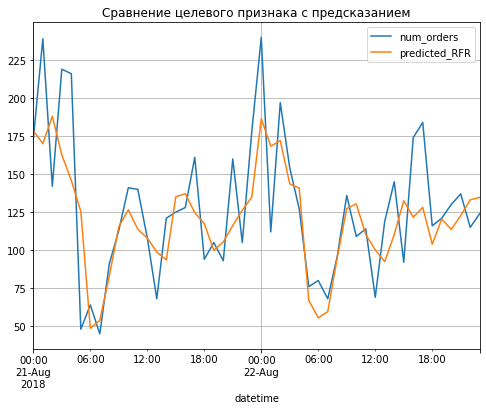

In [43]:
test_pred_RFR = pd.DataFrame(target_test).join(pd.Series(predicted_RFR, index=target_test.index, name='predicted_RFR'))

test_pred_RFR['2018-08-21':'2018-08-22'].plot(grid=True, figsize=(8,6))
plt.title('Сравнение целевого признака с предсказанием');

**Случайный лес** также справился, выполнив предсказания с RMSE равной 44. Эта модель также как и предыдущая, оказалась пессимистичной в прогнозах заказов в ночное время и 22 августа в утренние и вечерние часы. Зато она зависила спрос в районе полудня в оба дня.

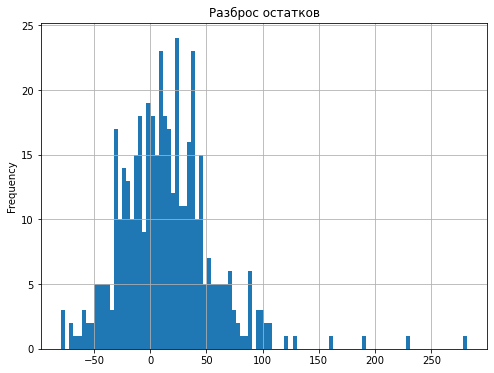

In [44]:
(target_test-predicted_RFR).plot(kind='hist', grid=True, bins=100, figsize=(8,6),
                                 title='Разброс остатков');

**Случайный лес** меньше ошибается с предсказаниями в положительную сторону. Основной разброс остатков укладывается в диапазон от -30 до 50 заказов, однако пики приходятся на 10, 25 и 35 заказов. Также видно, что есть хвост более 250.

Модель **CatBoost** у нас также уже определена на предыдущем шаге, поэтому сразу выполним предсказания и посмотрим на их точность.

In [45]:
predicted_CBR = model_CBR.predict(features_test)
RMSE_CBR_final = mean_squared_error(target_test, predicted_CBR)**0.5
RMSE_CBR_final

41.26986547977965

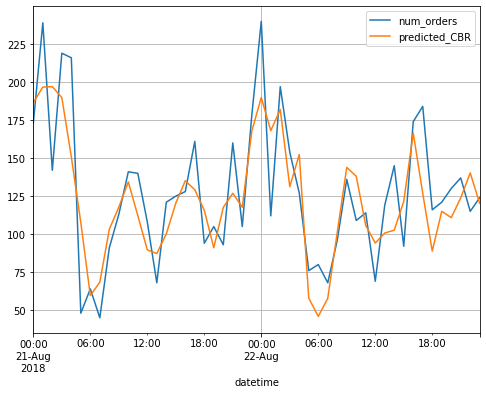

In [46]:
test_pred_CBR = pd.DataFrame(target_test).join(pd.Series(predicted_CBR, index=target_test.index, name='predicted_CBR'))

test_pred_CBR['2018-08-21':'2018-08-22'].plot(grid=True, figsize=(8,6));

Эта модель на тестовых данных выдала ошибку в 41 заказ и тоже справилась с задачей. Судя по графику она лучше всех справилась с предсказаниями, в основном ошибаясь незначительно. Однако, эта модель также сильно занизила спрос в полуночное время, а также 22 августа предсказала меньшее число заказов в 6 утра и 18:00 вечера.

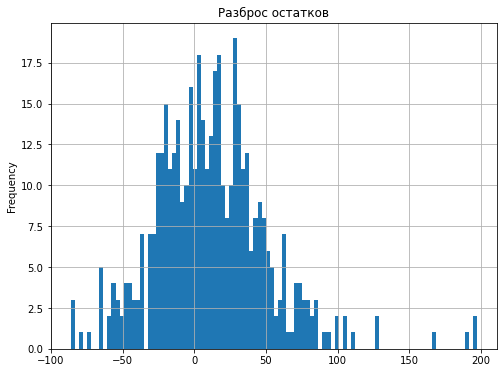

In [47]:
(target_test-predicted_CBR).plot(kind='hist', grid=True, bins=100, figsize=(8,6),
                                 title='Разброс остатков');

**CatBoost** справился с предсказаниями лучше всех. Основной разброс остатков в диапазоне от -40 до 40, что довольно хорошо, но чаще всего эта модель занижает предсказания на 25-30 заказов. Хвосты здесь не превышают 200 заказов.

Соберём все полученные результаты и сравним их.

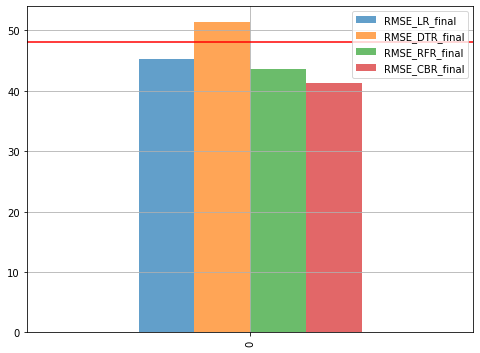

In [48]:
RMSE_all = pd.DataFrame({'RMSE_LR_final': [RMSE_LR_final],
                         'RMSE_DTR_final': [RMSE_DTR_final],
                         'RMSE_RFR_final': [RMSE_RFR_final],
                         'RMSE_CBR_final': [RMSE_CBR_final]
                        })
RMSE_all.plot(kind='bar', grid=True, figsize=(8,6), alpha=0.7);
plt.axhline(y=48, color='r', linestyle='-')
plt.show()

## Итоговый вывод

Сравнив результаты предсказаний четырёх моделей и оценив их качество, можно сказать, что только модель **дерева решений** не справилась с поставленной задачей и выдала RMSE 51, что хуже ожидаемой в 48. Остальные три модели справились, выдав необходимое качество предсказаний. Лучшей моделью оказалась **CatBoostRegressor**, её ошибка на тестовой выборке была минимальной - 41 заказ в час. Однако все модели плохо предсказывают спрос в полночь и не очень хорошо предсказывают заказы утром и вечером. Здесь нужно больше данных и более глубокий анализ причин количества заказов: возможно погода, в плохую погоду люди чаще пользуются услугами такси; цены у конкурентов, может быть цены у конкурентов ниже, отсюда спрос на наше такси ниже; расписание общественного транспорта возле аэропорта, который будет гораздо дешевле такси.